# Section Detection
---

In [1]:
from pathlib import Path
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
plt.set_cmap('magma')
%matplotlib inline

from skimage.io import imread, imsave
from skimage import img_as_float
from skimage import (transform, color, exposure, 
                     feature, draw, measure,
                     util, morphology, segmentation)

import section_detection as secdec

#### Ignore warnings

In [2]:
import warnings
warnings.filterwarnings('ignore')

## 1 Run through program stepwise
### 1.1 Preprocessing
#### Set parameters

In [3]:
size = 1200000 
sizeGlass = 19.15 #mm
sideSection = 0.736 #mm #size of one side of the section
delta = 0.23 #ratio
limit = 0.5
ratioGlassToPic = 0.8 #assuming the diameter of the sample glass is at least this much of the short side of the picture

In [132]:
export_dir = Path(r'M:\tnw\ist\do\projects\iCAT\projects\section_detection\isabel_summary\summary_pics')

#### Load image

In [4]:
im_fn = Path('./20180917_RP-april.jpg').absolute()
im = img_as_float(imread(im_fn))

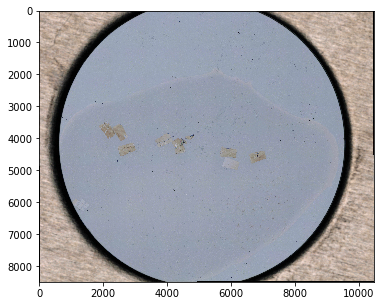

In [5]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(im);

#### Downsize
`section_detection.downsizeTo` contains `anti_aliasing = False` among other questionable things... Though it does seem to work out all right.

In [6]:
imds = secdec.downsizeTo(im, size)

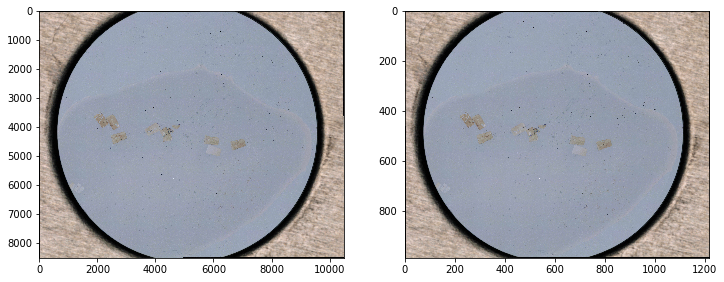

In [7]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
ax1.imshow(im);
ax2.imshow(imds);

#### DAB

In [13]:
imCircle = secdec.dab(imds, 20)

In [133]:
imsave(export_dir / 'imds.png', imds)
imsave(export_dir / 'imCircle.png', imCircle)

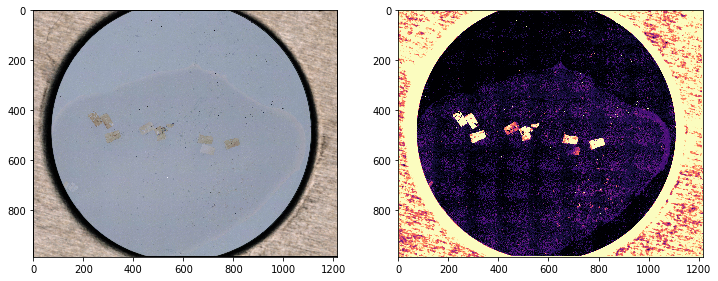

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
ax1.imshow(imds);
ax2.imshow(imCircle);

### 1.2 Circle stuff
#### Canny edge finding

In [140]:
edgesCircle = feature.canny(imCircle, sigma=1.5, low_threshold=0, high_threshold=1)

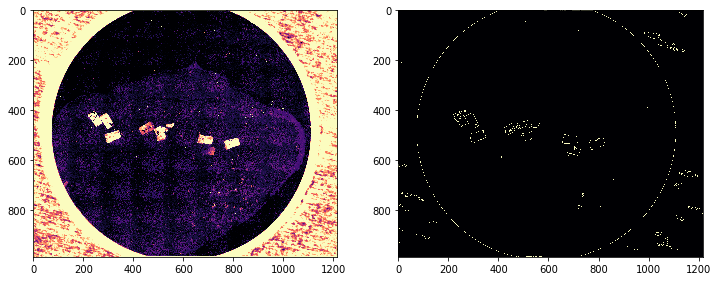

In [141]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
ax1.imshow(imCircle);
ax2.imshow(edgesCircle);

#### Find circle

In [138]:
circx, circy = secdec.findCircle(edgesCircle, ratio=0.8)

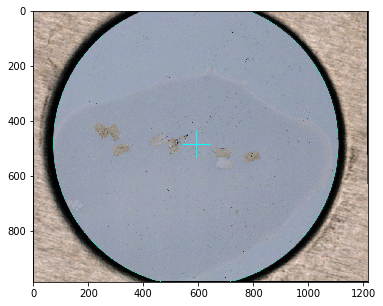

In [157]:
mask = imds.copy()
circy_f = circy[(0<circy) & (circy<mask.shape[0]) & (0<circx) & (circx<mask.shape[1])]
circx_f = circx[(0<circy) & (circy<mask.shape[0]) & (0<circx) & (circx<mask.shape[1])]
mask[circy_f, circx_f] = (0.1, 0.9, 0.7)

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(mask);
w = 50  # crosshair width (half)
cx = (circx.min() + circx.max()) / 2
cy = (circy.min() + circy.max()) / 2
ax.vlines(cx, cy-w, cy+w, color='#00FFFF', lw=1);
ax.hlines(cy, cx-w, cx+w, color='#00FFFF', lw=1);

#### Crop to circle

In [58]:
imctc = secdec.cropToCircle(imds, circx, circy)

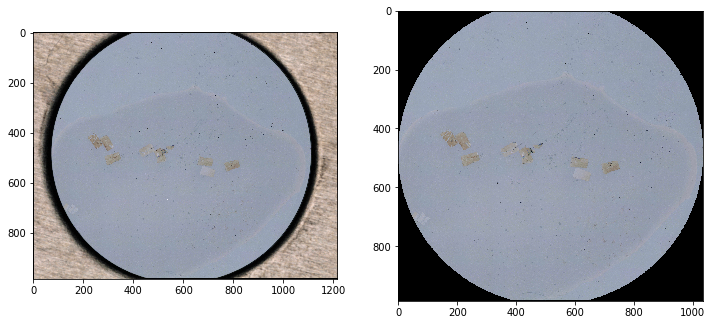

In [158]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
ax1.imshow(imds);
ax2.imshow(imctc);

### 1.3 First method
#### Convert to HED color space and adjust intensity levels

In [61]:
mm = imctc.shape[0] / sizeGlass
sideSectionPix = sideSection*mm

In [160]:
imEdges = secdec.SSI(imctc, pr1=1.1)
edges = feature.canny(imEdges, sigma=1.8, low_threshold=0, high_threshold=1)
edges = secdec.cropToCircle(edges, circx, circy, crop=False, returnBool=True)

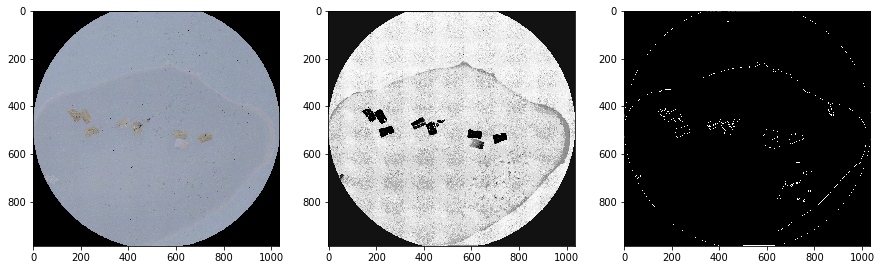

In [163]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5))
ax1.imshow(imctc);
ax2.imshow(imEdges, cmap='Greys_r');
ax3.imshow(edges, cmap='Greys_r');

#### Blackout circle

In [172]:
imboc = secdec.blackoutCircle(edges, circx_f, circy_f, d=0.02)

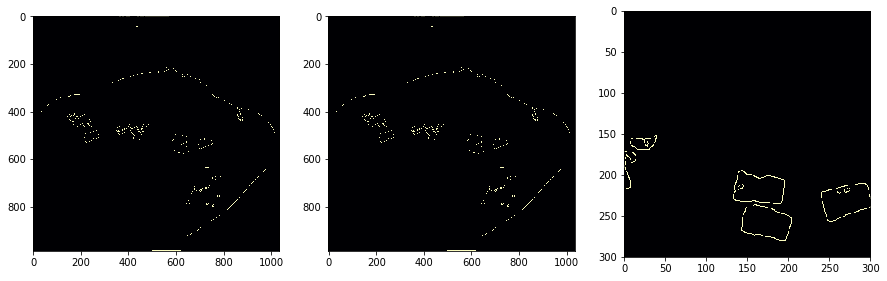

In [173]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5))
ax1.imshow(edges);
ax2.imshow(imboc);
ax3.imshow(imboc[300:600, 450:750]);

In [174]:
imsave(export_dir / 'imboc.png', img_as_ubyte(imboc))

#### Find half circle

In [75]:
deltaPix = 0.23 * sideSectionPix
check = secdec.findHalfCircle(sideSectionPix, deltaPix)

#### Select fill edges

In [77]:
viaEdges = secdec.selectFillEdges(imboc, check, lim=0.5, delta=deltaPix)

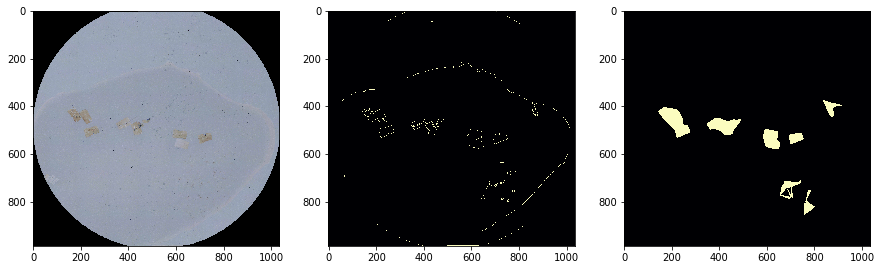

In [80]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5))
ax1.imshow(imctc);
ax2.imshow(imboc);
ax3.imshow(viaEdges);

### 1.4 Second method
#### Convert to HED color space and adjust intensity levels

In [83]:
imfz = secdec.SSI(imctc, pr1=7.6)

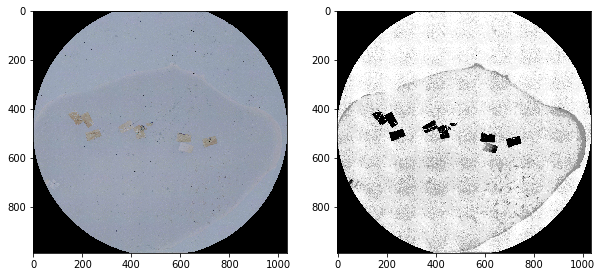

In [176]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
ax1.imshow(imctc);
ax2.imshow(imfz, cmap='Greys_r');

#### Felzenswalb segmentation

In [120]:
scale = 20 * sideSectionPix
sigma = 2.4
min_size = int(sideSectionPix**2 / 5)
viafz = segmentation.felzenszwalb(imfz, scale=scale*3, sigma=sigma*1, min_size=int(min_size*1))

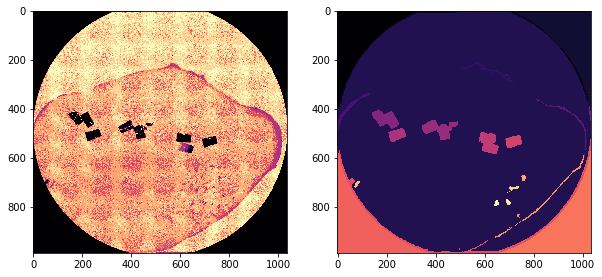

In [178]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
ax1.imshow(imfz);
ax2.imshow(viafz);

#### Find sections (Felzenswalb style)

In [122]:
secfz = secdec.findSectionsFz(viafz)

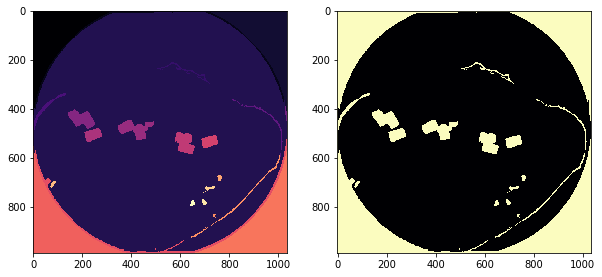

In [123]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
ax1.imshow(viafz);
ax2.imshow(secfz);

#### Crop to circle

In [124]:
viafzctc = secdec.cropToCircle(viafz, circx, circy, crop=False, returnBool=True)

### 1.5 Union methods
#### Overlap

In [125]:
sections = secdec.overlap(viaEdges, secfz)

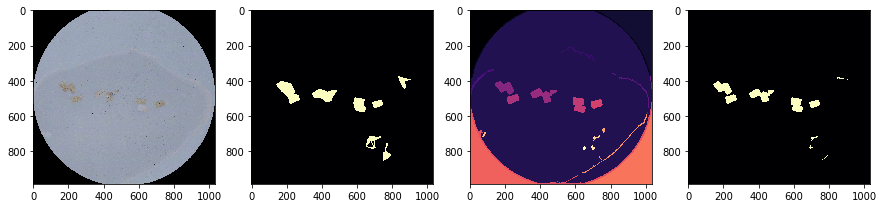

In [126]:
fig, axes = plt.subplots(ncols=4, figsize=(15, 5))
axes[0].imshow(imctc);
axes[1].imshow(viaEdges);
axes[2].imshow(viafz);
axes[3].imshow(sections);

In [183]:
imsave(export_dir / 'sections.png', img_as_ubyte(sections))

## 2 All at once

total ellapsed time =  237


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

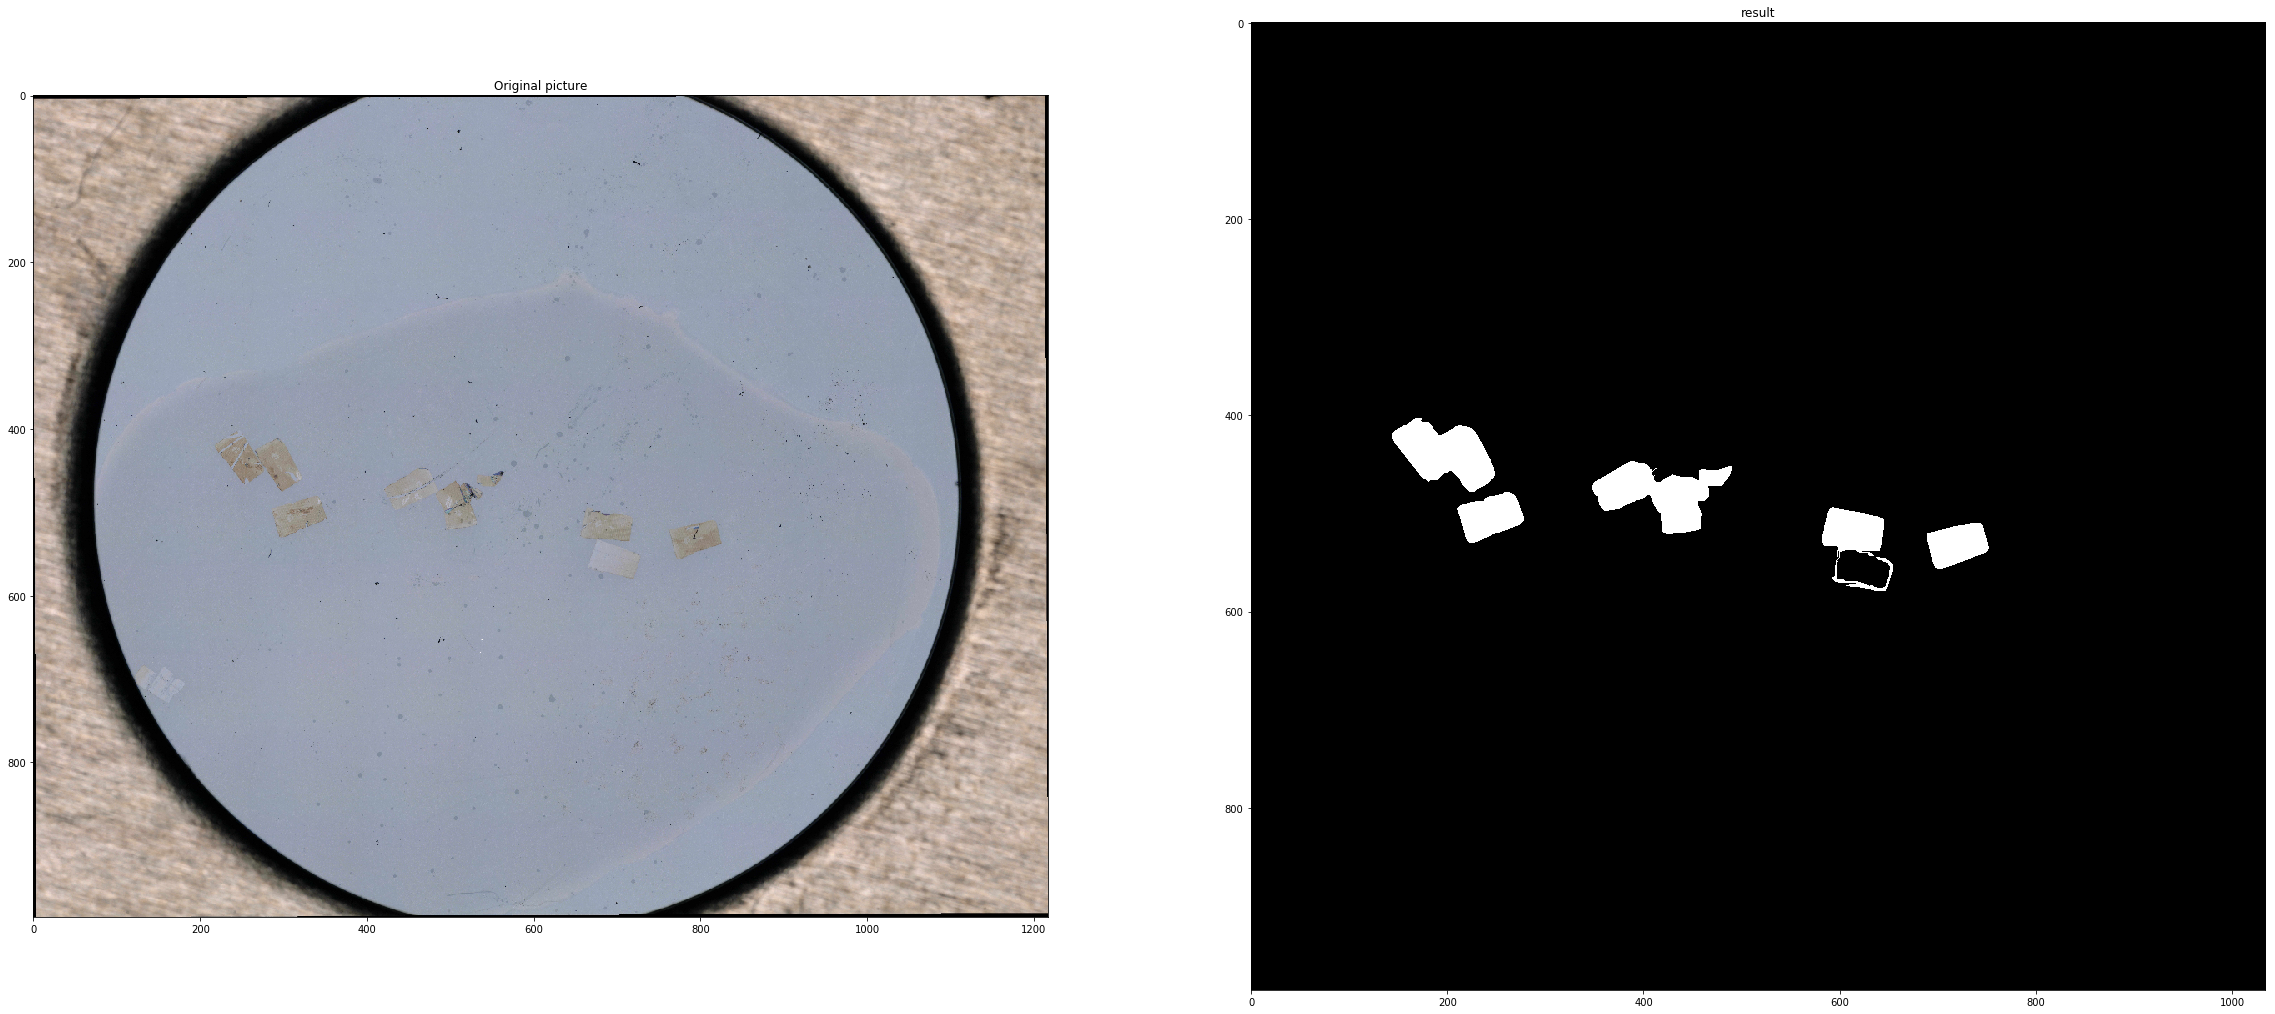

In [127]:
secdec.detectSections(im_fn.as_posix())